In [1]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional, Conv1D, Concatenate
import matplotlib.pyplot as plt

2025-04-13 11:21:53.594313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Set up directories
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

DIRECTORY = '.'
SUMMARY_PATH = 'NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = 'NLP_app/MutualFundLabels.csv'

glove_word2vec = 'NLP_app/word2vec_perso.txt'
our_word2vec = 'NLP_app/word2vec_perso.txt'

# Utility functions
 

In [3]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename, word2vec):
    with open(os.path.join('./', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('./', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    
    # Uses only funds in rag_preds, which are funds with the 3 relevant strategies
    rag_preds = pd.read_csv("rag_predictions.csv")
    relevant_funds = list(rag_preds['fund_name'])
    
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        if fund_name in relevant_funds:
            texts.append(summary)
            fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

## Tokenize fund summaries

In [4]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [5]:
# Get the summaries that use one of the 3 relevant investment strategies
fund_names, summaries = get_data(SUMMARY_PATH)

In [6]:
# Clean and tokenize text - remove whitespace, tokenize words, keep only alphabetic chars, remove stopwords
def tokenizer(txt: str) -> list[str]:
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = []
    for w in word_tokens:
        w_clean = re.sub(r'[^a-zA-Z]', '', w)
        if w_clean and w_clean not in stop_words:
            filtered_sentence.append(w_clean)
    
    return filtered_sentence

In [7]:
# Make one list of all tokenized words from each summary
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

## Set up for skip-gram model

In [8]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

In [9]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector, also size of hidden layer
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [10]:
# Makes dictionary of words to word frequency for frequency > min_occurrence
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [11]:
# Create id's for each word and create 2 dictionary to access in both directions
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)   

In [12]:
# Create data - list of text_words where words are converted to their id's
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [13]:
# Build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [14]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

## Train the skip-gram model

In [15]:
# Create and compile the Autoencoder
def creat_word2vec_model():
    # One-hot encoded vector input vector
    input_word = Input(shape=(vocab_size,))
    # Embedded layer - maps input vector to embedding vector
    encoded = Dense(embedding_size, activation='linear')(input_word)
    # Output layer - maps embedding vector to probability of a context word
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [16]:
# Create word2vec model
encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3105)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       155,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3105)           │       158,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,655 (1.20 MB)

 Trainable params: 313,655 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train model using batch generator
autoencoder.fit(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2
6363/6363 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 0.0611
Epoch 2/2
6363/6363 ━━━━━━━━━━━━━━━━━━━━ 65s 10ms/step - loss: 0.0024


## Use encoder

In [18]:
# Word to one_hot vecotor to dense vector
def vectorize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [19]:
# Create the word2vec dictionary - dictionary of word to dense vector
word2vec = {w : vectorize(w) for w in word2id.keys()}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━

In [20]:
# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec, word2vec)

# C- Sentence extraction

<h3> 1_ Create a knowledge base </h3>

In [21]:
equity_keywords = [
    "equity", "equities", "stock", "stocks", "shares", "common", "capital",
    "appreciation", "growth", "dividends", "midcap",
    "technology", "healthcare", "consumer", "industrials", "portfolio"
]
fixed_income_keywords = [
    "bond", "bonds", "debt", "coupon", "yield", "duration", "interest", "income",
    "fixed", "maturity", "treasury", "municipal", "corporate", "principal", "credit", "rates", "stable"
]
balanced_keywords = [
    "balanced", "diversified", "allocation", "blend", "mix", "strategy",
    "equities", "bonds", "stocks", "fixed", "income", "growth", "capital", 
    "preservation", "stability", "moderate", "hybrid", "rebalancing"
]

In [22]:
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [23]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [24]:
#word2vec = load_word2vec(our_word2vec)
eq_knowledge_base = create_knowledge_base(5, word2vec, equity_keywords)
fi_knowledge_base = create_knowledge_base(5, word2vec, fixed_income_keywords)
bal_knowledge_base = create_knowledge_base(5, word2vec, balanced_keywords)

In [25]:
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv('rag_predictions.csv')
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()

In [26]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [27]:
df['eq_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], eq_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['fi_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], fi_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['bal_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], bal_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [28]:
df.to_csv("dataset.csv")

## Making the Model

In [29]:
X = df[['eq_sentences', 'fi_sentences', 'bal_sentences']]
for col in ['eq_sentences', 'fi_sentences', 'bal_sentences']:
    X[col] = X[col].fillna('').apply(lambda txt: ' '.join(tokenizer(txt)))

y = df['Predicted Investment Strategy'].values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


/var/folders/jx/vhdxb7ks06710zlsb29bkz000000gn/T/ipykernel_49737/2951265711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna('').apply(lambda txt: ' '.join(tokenizer(txt)))


In [30]:
# num_words - Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
# maxlen - Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
# word_dimension - dimension of our word vectors.
def run_CNN(num_words, maxlen, word_dimension):    
    word2vec_g = word2vec
    tokenizer_eq = Tokenizer(num_words=num_words)
    tokenizer_fi = Tokenizer(num_words=num_words)
    tokenizer_bal = Tokenizer(num_words=num_words)

    # Fit on texts
    tokenizer_eq.fit_on_texts(X['eq_sentences'])
    tokenizer_fi.fit_on_texts(X['fi_sentences'])
    tokenizer_bal.fit_on_texts(X['bal_sentences'])
    word_index_eq = tokenizer_eq.word_index
    word_index_fi = tokenizer_fi.word_index
    word_index_bal = tokenizer_bal.word_index

    # Convert texts to sequences
    seq_eq = tokenizer_eq.texts_to_sequences(X['eq_sentences'])
    seq_fi = tokenizer_fi.texts_to_sequences(X['fi_sentences'])
    seq_bal = tokenizer_bal.texts_to_sequences(X['bal_sentences'])

    # Pad sequences to uniform length
    X_eq = pad_sequences(seq_eq, maxlen=maxlen, padding='post')
    X_fi = pad_sequences(seq_fi, maxlen=maxlen, padding='post')
    X_bal = pad_sequences(seq_bal, maxlen=maxlen, padding='post')

    # First split: train + temp (temp will later be split into val and test)
    X_eq_train, X_eq_temp, X_fi_train, X_fi_temp, X_bal_train, X_bal_temp, y_train, y_temp = train_test_split(
        X_eq, X_fi, X_bal, y, test_size=0.3, random_state=42
    )

    # Second split: temp → val and test (e.g., 15% each)
    X_eq_val, X_eq_test, X_fi_val, X_fi_test, X_bal_val, X_bal_test, y_val, y_test = train_test_split(
        X_eq_temp, X_fi_temp, X_bal_temp, y_temp, test_size=0.5, random_state=42
    )

    embedding_matrix_eq = np.zeros((len(word_index_eq) + 1, word_dimension))
    for word, i in word_index_eq.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_eq[i] = embedding_vector

    embedding_matrix_fi = np.zeros((len(word_index_fi) + 1, word_dimension))
    for word, i in word_index_fi.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_fi[i] = embedding_vector
            
    embedding_matrix_bal = np.zeros((len(word_index_bal) + 1, word_dimension))
    for word, i in word_index_bal.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_bal[i] = embedding_vector

    def create_CNN_branch(input_shape, embedding_matrix, name_prefix="input"):
        input_layer = Input(shape=input_shape, name=f"{name_prefix}_input")

        x = Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=input_shape[0],
            trainable=False,
            name=f"{name_prefix}_embedding"
        )(input_layer)

        x = Conv1D(64, 5, activation='relu')(x)
        x = MaxPooling1D(pool_size=5)(x)

        x = Conv1D(32, 5, activation='relu')(x)
        x = MaxPooling1D(pool_size=5)(x)

        x = Flatten()(x)
        return input_layer, x

    def create_CNN_model_multi_input(embedding_eq, embedding_fi, embedding_bal, maxlen):
        # Each branch
        eq_input, eq_branch = create_CNN_branch((maxlen,), embedding_eq, "eq")
        fi_input, fi_branch = create_CNN_branch((maxlen,), embedding_fi, "fi")
        bal_input, bal_branch = create_CNN_branch((maxlen,), embedding_bal, "bal")

        # Merge
        merged = Concatenate()([eq_branch, fi_branch, bal_branch])
        x = Dense(128, activation='relu')(merged)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)

        model = Model(inputs=[eq_input, fi_input, bal_input], outputs=output)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    CNN_model = create_CNN_model_multi_input(embedding_matrix_eq, embedding_matrix_fi, embedding_matrix_bal, maxlen)

    CNN_history = CNN_model.fit(
        [X_eq_train, X_fi_train, X_bal_train], y_train,
        validation_data=([X_eq_val, X_fi_val, X_bal_val], y_val),
        epochs=10,
        batch_size=32
    )

    acc = CNN_history.history['accuracy']
    val_acc = CNN_history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Predict labels
    y_pred = CNN_model.predict([X_eq_test, X_fi_test, X_bal_test])
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Balanced', 'Equity', 'Fixed Income'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()





Num_words: 1500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.5230 - loss: 1.0699 - val_accuracy: 0.5217 - val_loss: 0.9972
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5112 - loss: 1.0359 - val_accuracy: 0.5217 - val_loss: 0.9882
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5551 - loss: 0.9929 - val_accuracy: 0.5217 - val_loss: 0.9948
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5661 - loss: 0.9818 - val_accuracy: 0.5507 - val_loss: 0.9736
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5138 - loss: 0.9843 - val_accuracy: 0.5507 - val_loss: 0.9716
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5499 - loss: 1.0125 - val_accuracy: 0.5362 - val_loss: 0.9626
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5670 - loss: 0.9828 - val_accuracy: 0.5362 - val_loss: 0.9614
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5465 - loss: 0.9582 - val_accuracy: 0.5362 - val_loss: 0

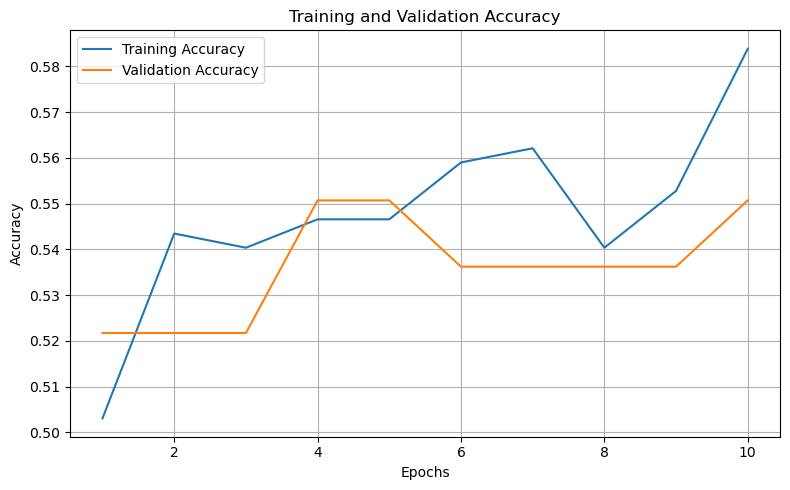

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


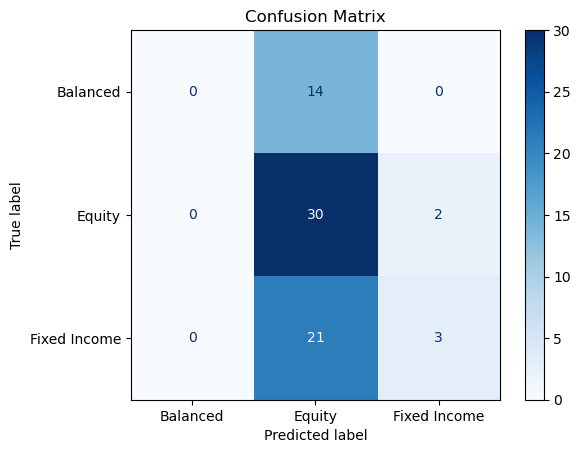




Num_words: 1500
maxlen: 200
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4550 - loss: 1.1103 - val_accuracy: 0.5217 - val_loss: 0.9960
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5456 - loss: 0.9963 - val_accuracy: 0.5217 - val_loss: 0.9702
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5863 - loss: 0.9558 - val_accuracy: 0.5507 - val_loss: 0.9406
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5729 - loss: 0.9556 - val_accuracy: 0.5507 - val_loss: 0.9450
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5680 - loss: 0.9580 - val_accuracy: 0.5507 - val_loss: 0.9429
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5745 - loss: 0.9282 - val_accuracy: 0.5652 - val_loss: 0.9393
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6351 - loss: 0.8843 - val_accuracy: 0.6087 - val_loss: 0.9177
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6093 - loss: 0.8842 - val_accuracy: 0.5797 - val_loss: 0.

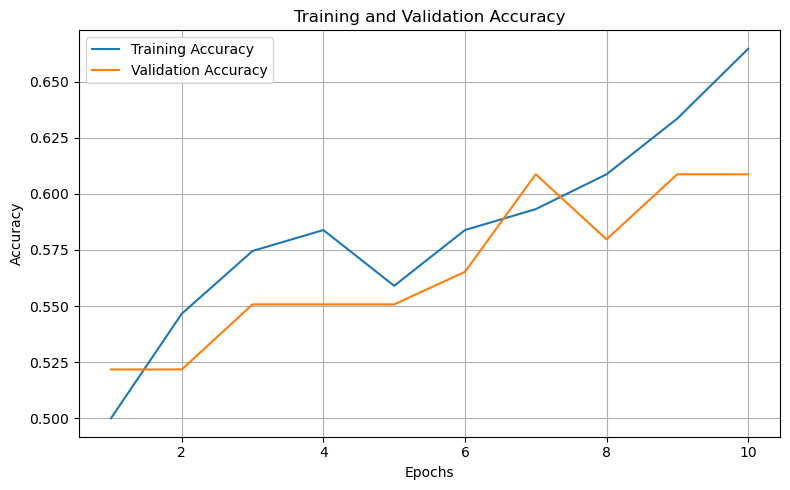

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


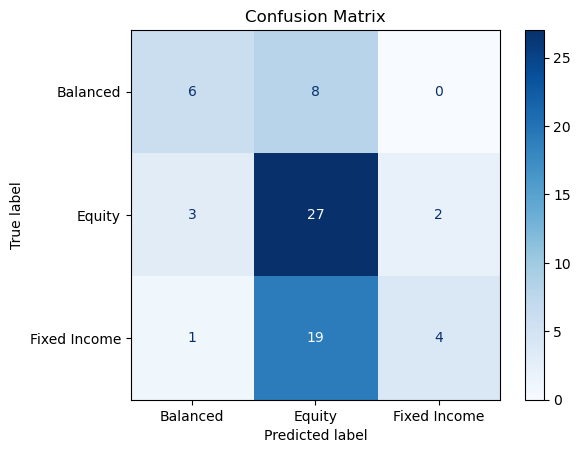




Num_words: 1500
maxlen: 300
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.4373 - loss: 1.0812 - val_accuracy: 0.5217 - val_loss: 1.0242
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5323 - loss: 1.0135 - val_accuracy: 0.5217 - val_loss: 0.9728
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5410 - loss: 0.9963 - val_accuracy: 0.5217 - val_loss: 0.9603
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5465 - loss: 0.9813 - val_accuracy: 0.5217 - val_loss: 0.9460
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5975 - loss: 0.9294 - val_accuracy: 0.5362 - val_loss: 0.9441
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5818 - loss: 0.9081 - val_accuracy: 0.5507 - val_loss: 0.9393
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5948 - loss: 0.9050 - val_accuracy: 0.6087 - val_loss: 0.9077
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6551 - loss: 0.8404 - val_accuracy: 0.5797 - val_loss: 0.

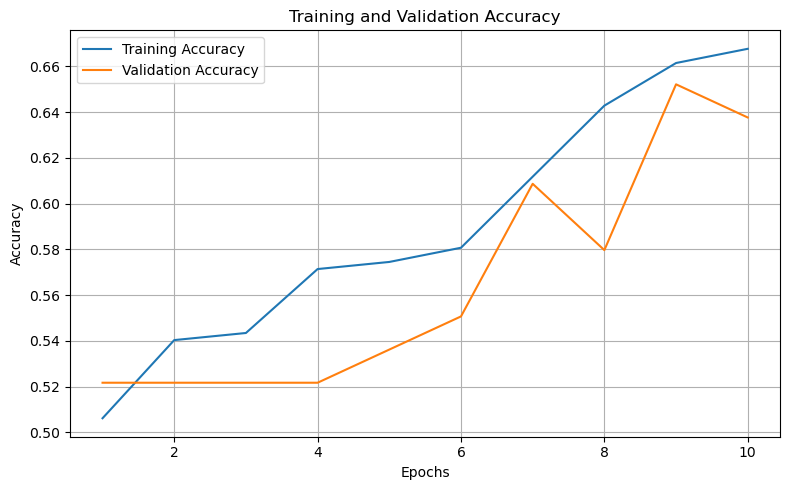

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


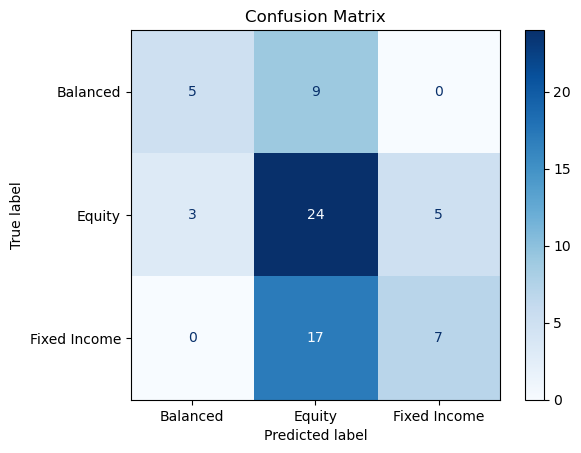




Num_words: 1500
maxlen: 400
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.4497 - loss: 1.0897 - val_accuracy: 0.5217 - val_loss: 1.0052
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5298 - loss: 1.0030 - val_accuracy: 0.5217 - val_loss: 1.0217
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5367 - loss: 1.0322 - val_accuracy: 0.5217 - val_loss: 0.9758
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5292 - loss: 0.9853 - val_accuracy: 0.5217 - val_loss: 0.9630
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5457 - loss: 0.9384 - val_accuracy: 0.5217 - val_loss: 0.9609
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5762 - loss: 0.9341 - val_accuracy: 0.5507 - val_loss: 0.9439
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5777 - loss: 0.9044 - val_accuracy: 0.5362 - val_loss: 0.9165
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6036 - loss: 0.8481 - val_accuracy: 0.5652 - val_loss: 0

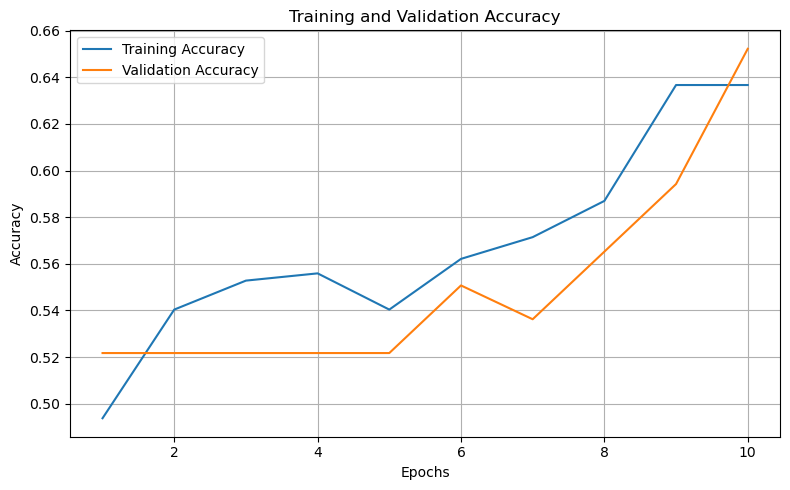

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


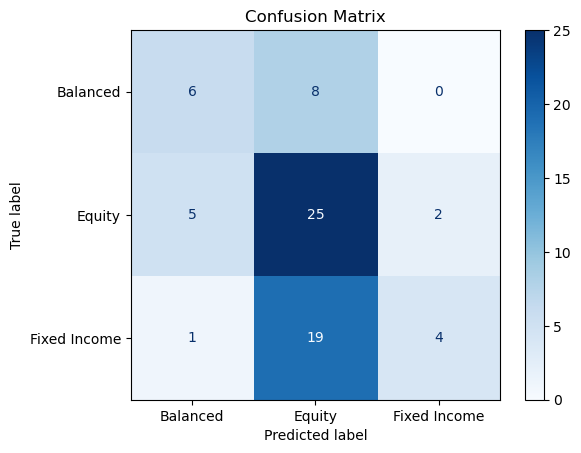




Num_words: 1500
maxlen: 500
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.5062 - loss: 1.0580 - val_accuracy: 0.5217 - val_loss: 0.9933
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5737 - loss: 0.9770 - val_accuracy: 0.5217 - val_loss: 0.9881
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5351 - loss: 0.9954 - val_accuracy: 0.5507 - val_loss: 0.9725
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5480 - loss: 0.9565 - val_accuracy: 0.5652 - val_loss: 0.9740
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5670 - loss: 0.9520 - val_accuracy: 0.5652 - val_loss: 0.9586
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6320 - loss: 0.9025 - val_accuracy: 0.5507 - val_loss: 0.9411
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5827 - loss: 0.9402 - val_accuracy: 0.5652 - val_loss: 0.9492
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5731 - loss: 0.8852 - val_accuracy: 0.5507 - val_loss: 0.

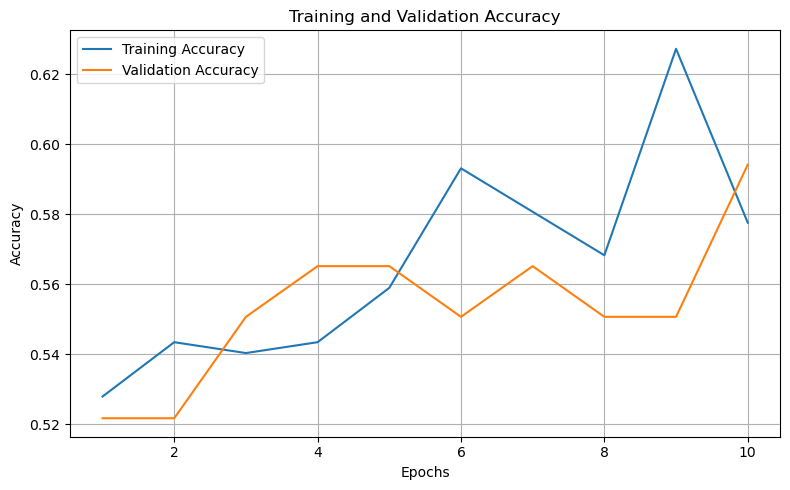

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


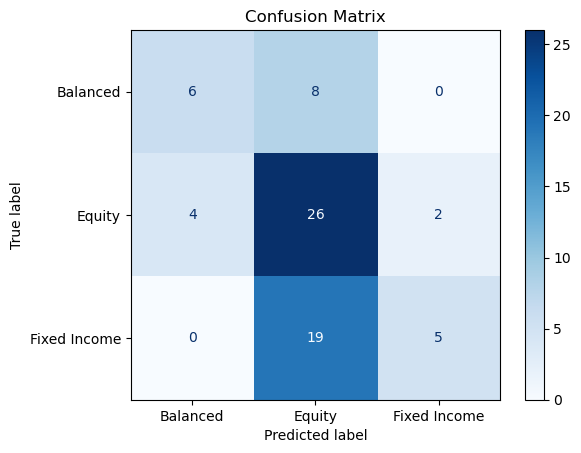




Num_words: 1500
maxlen: 600
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.4985 - loss: 1.0423 - val_accuracy: 0.5217 - val_loss: 1.0028
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5199 - loss: 1.0270 - val_accuracy: 0.5217 - val_loss: 0.9872
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5299 - loss: 0.9908 - val_accuracy: 0.5217 - val_loss: 0.9875
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5646 - loss: 0.9806 - val_accuracy: 0.5217 - val_loss: 0.9977
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5653 - loss: 0.9476 - val_accuracy: 0.5217 - val_loss: 0.9821
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5540 - loss: 0.9465 - val_accuracy: 0.5507 - val_loss: 0.9557
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6125 - loss: 0.9268 - val_accuracy: 0.5507 - val_loss: 0.9388
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5990 - loss: 0.8907 - val_accuracy: 0.5942 - val_loss: 0

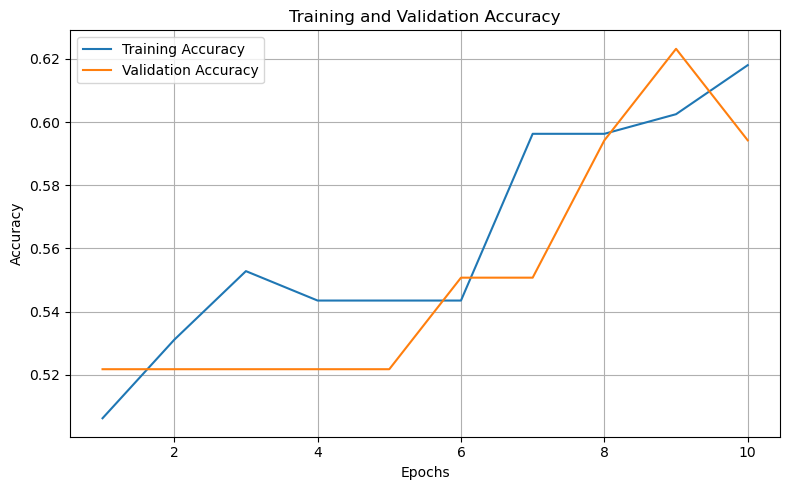

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


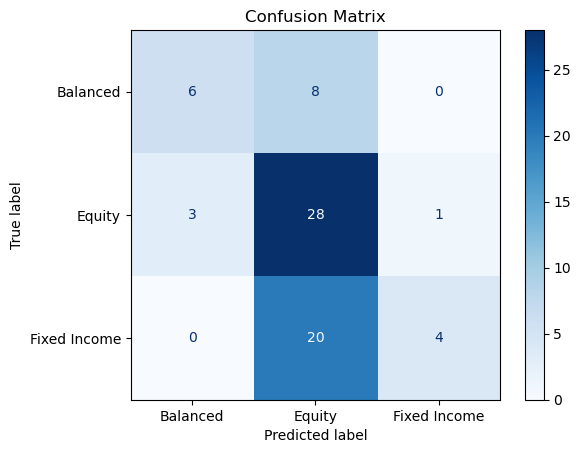




Num_words: 2500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.4507 - loss: 1.1005 - val_accuracy: 0.5217 - val_loss: 1.0079
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5106 - loss: 1.0690 - val_accuracy: 0.5217 - val_loss: 1.0004
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5295 - loss: 1.0291 - val_accuracy: 0.5217 - val_loss: 0.9893
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5717 - loss: 0.9846 - val_accuracy: 0.5217 - val_loss: 0.9915
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5323 - loss: 0.9964 - val_accuracy: 0.5217 - val_loss: 0.9881
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5613 - loss: 0.9685 - val_accuracy: 0.5217 - val_loss: 0.9985
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4962 - loss: 0.9983 - val_accuracy: 0.5217 - val_loss: 0.9688
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5608 - loss: 0.9793 - val_accuracy: 0.5507 - val_loss: 0.

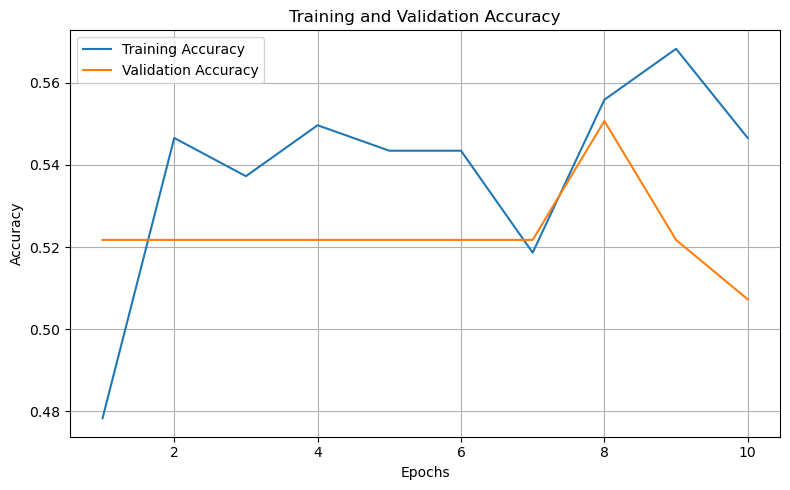

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


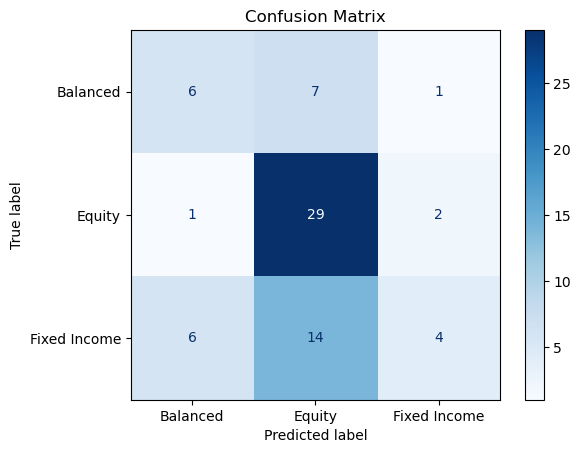




Num_words: 2500
maxlen: 200
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.4072 - loss: 1.0991 - val_accuracy: 0.5217 - val_loss: 0.9887
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5413 - loss: 0.9749 - val_accuracy: 0.5217 - val_loss: 0.9786
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5520 - loss: 0.9773 - val_accuracy: 0.5217 - val_loss: 0.9607
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5628 - loss: 0.9546 - val_accuracy: 0.5652 - val_loss: 0.9518
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5656 - loss: 0.9632 - val_accuracy: 0.5507 - val_loss: 0.9294
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5648 - loss: 0.8751 - val_accuracy: 0.5942 - val_loss: 0.8943
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5958 - loss: 0.8550 - val_accuracy: 0.5652 - val_loss: 0.8620
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6417 - loss: 0.8537 - val_accuracy: 0.6232 - val_loss: 0.

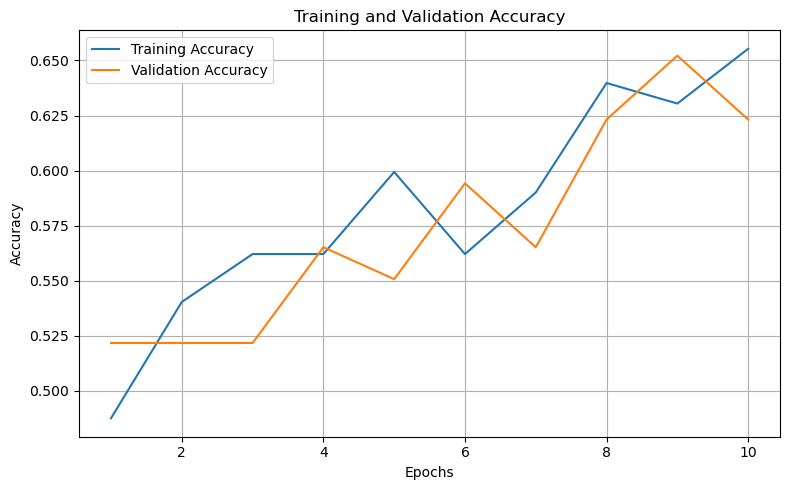

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


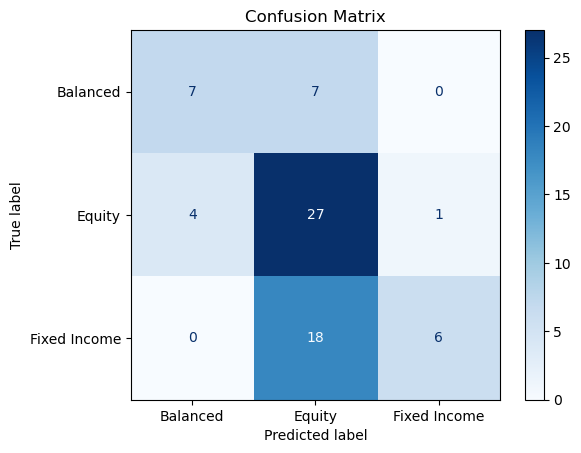




Num_words: 2500
maxlen: 300
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.3998 - loss: 1.1183 - val_accuracy: 0.5217 - val_loss: 1.0011
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5314 - loss: 1.0038 - val_accuracy: 0.5217 - val_loss: 0.9541
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5714 - loss: 0.9928 - val_accuracy: 0.5217 - val_loss: 0.9489
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5261 - loss: 1.0075 - val_accuracy: 0.5217 - val_loss: 0.9616
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5742 - loss: 0.9149 - val_accuracy: 0.5797 - val_loss: 0.9446
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5466 - loss: 0.9396 - val_accuracy: 0.5507 - val_loss: 0.8932
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6235 - loss: 0.8628 - val_accuracy: 0.6087 - val_loss: 0.8726
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6319 - loss: 0.8427 - val_accuracy: 0.6232 - val_loss: 0.

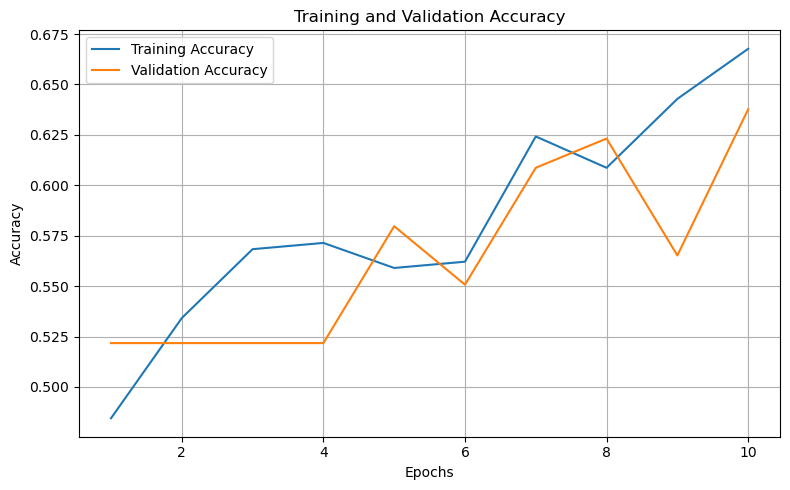

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


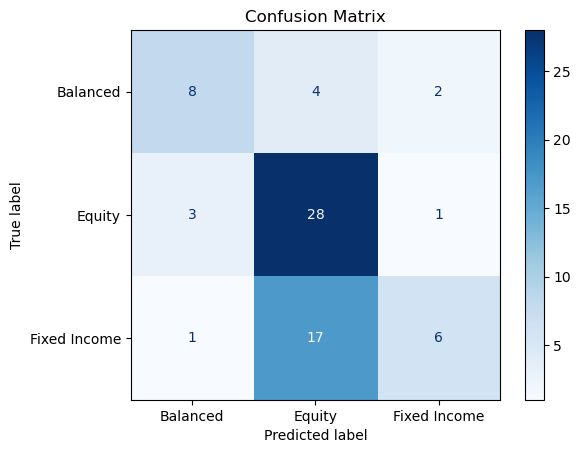




Num_words: 2500
maxlen: 400
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.4445 - loss: 1.0503 - val_accuracy: 0.5217 - val_loss: 0.9939
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5279 - loss: 1.0569 - val_accuracy: 0.5217 - val_loss: 0.9660
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5404 - loss: 0.9573 - val_accuracy: 0.5217 - val_loss: 0.9436
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5575 - loss: 0.9392 - val_accuracy: 0.5507 - val_loss: 0.9181
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5766 - loss: 0.9427 - val_accuracy: 0.5507 - val_loss: 0.9115
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6071 - loss: 0.8908 - val_accuracy: 0.6232 - val_loss: 0.8764
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6144 - loss: 0.8682 - val_accuracy: 0.6087 - val_loss: 0.8619
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6482 - loss: 0.8516 - val_accuracy: 0.6087 - val_loss: 0.

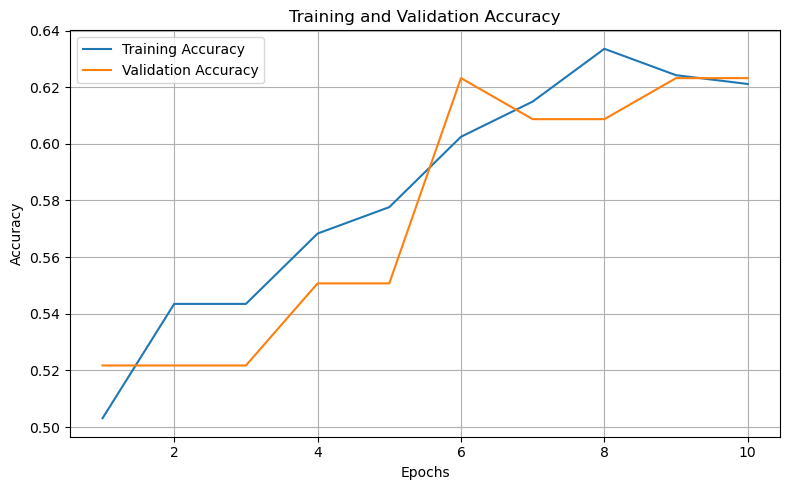

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


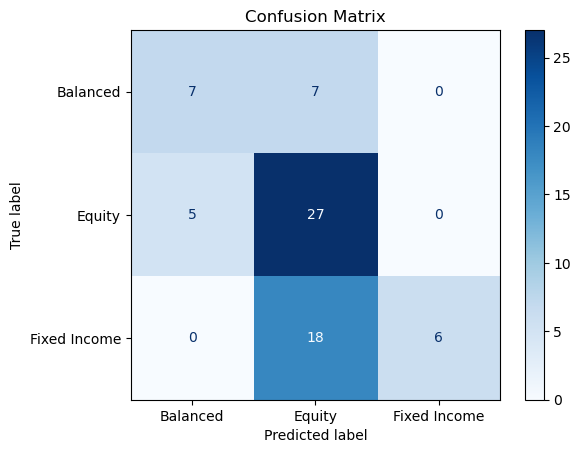




Num_words: 2500
maxlen: 500
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.4790 - loss: 1.0465 - val_accuracy: 0.5217 - val_loss: 0.9933
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5680 - loss: 0.9888 - val_accuracy: 0.5217 - val_loss: 0.9562
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5528 - loss: 0.9489 - val_accuracy: 0.5797 - val_loss: 0.9527
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5442 - loss: 0.9672 - val_accuracy: 0.5217 - val_loss: 0.9336
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5821 - loss: 0.9254 - val_accuracy: 0.5507 - val_loss: 0.9196
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5299 - loss: 1.0086 - val_accuracy: 0.6377 - val_loss: 0.8785
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6079 - loss: 0.8922 - val_accuracy: 0.6087 - val_loss: 0.8767
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6226 - loss: 0.8424 - val_accuracy: 0.5942 - val_loss: 0

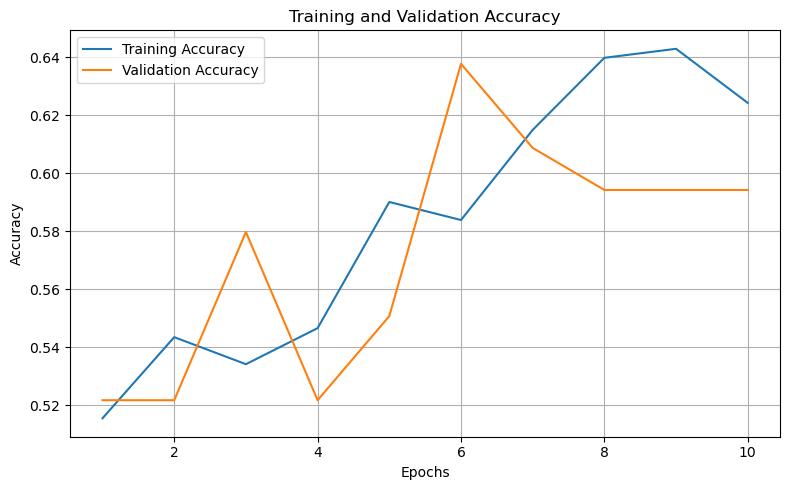

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


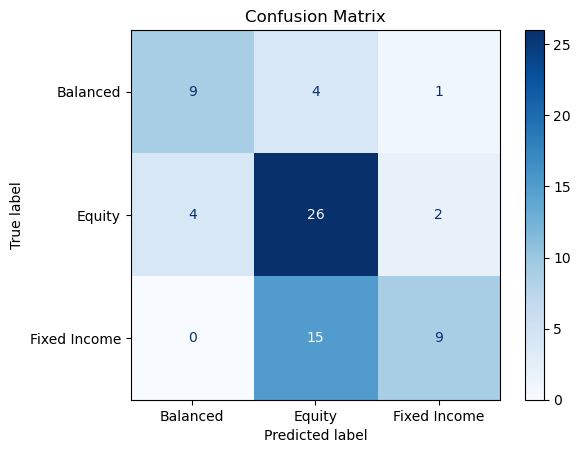




Num_words: 2500
maxlen: 600
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.5468 - loss: 1.0411 - val_accuracy: 0.5217 - val_loss: 0.9758
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5279 - loss: 0.9976 - val_accuracy: 0.5217 - val_loss: 0.9573
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5270 - loss: 0.9821 - val_accuracy: 0.5217 - val_loss: 0.9412
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5635 - loss: 0.9415 - val_accuracy: 0.5507 - val_loss: 0.9175
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5749 - loss: 0.9192 - val_accuracy: 0.5507 - val_loss: 0.9119
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5620 - loss: 0.9246 - val_accuracy: 0.5507 - val_loss: 0.8973
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5944 - loss: 0.9258 - val_accuracy: 0.6087 - val_loss: 0.8624
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6347 - loss: 0.8315 - val_accuracy: 0.5942 - val_loss: 0.

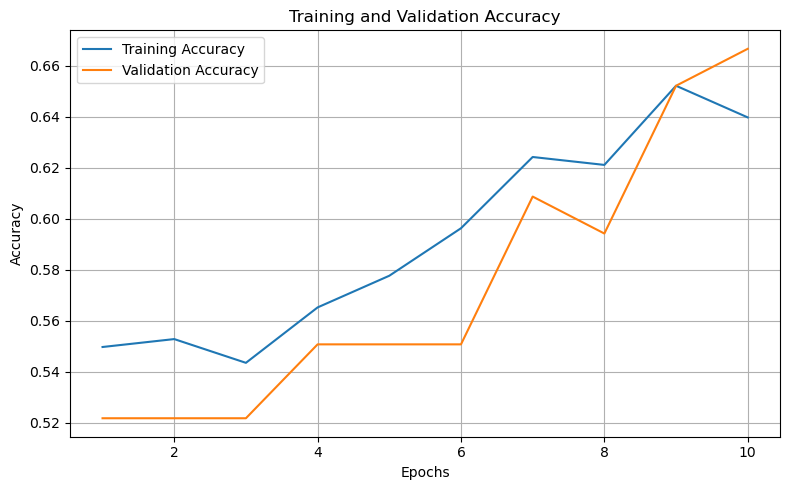

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


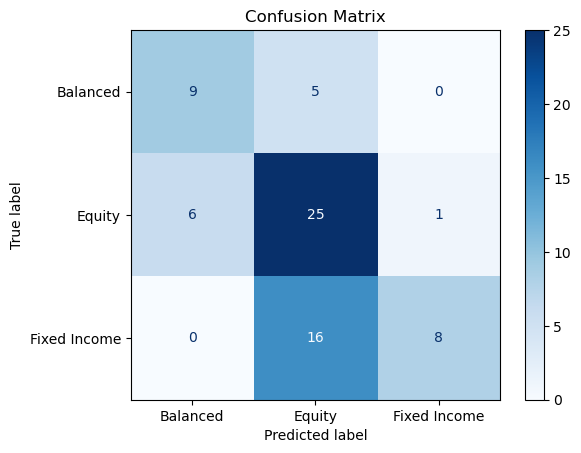




Num_words: 3500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4560 - loss: 1.0683 - val_accuracy: 0.5217 - val_loss: 1.0029
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5351 - loss: 0.9848 - val_accuracy: 0.5217 - val_loss: 1.0070
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4528 - loss: 1.0547 - val_accuracy: 0.5217 - val_loss: 0.9868
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5261 - loss: 1.0250 - val_accuracy: 0.5217 - val_loss: 0.9899
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5703 - loss: 0.9889 - val_accuracy: 0.5507 - val_loss: 0.9714
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5825 - loss: 0.9491 - val_accuracy: 0.5507 - val_loss: 0.9606
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5934 - loss: 0.9499 - val_accuracy: 0.5507 - val_loss: 0.9621
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5918 - loss: 0.9427 - val_accuracy: 0.5507 - val_loss: 0.

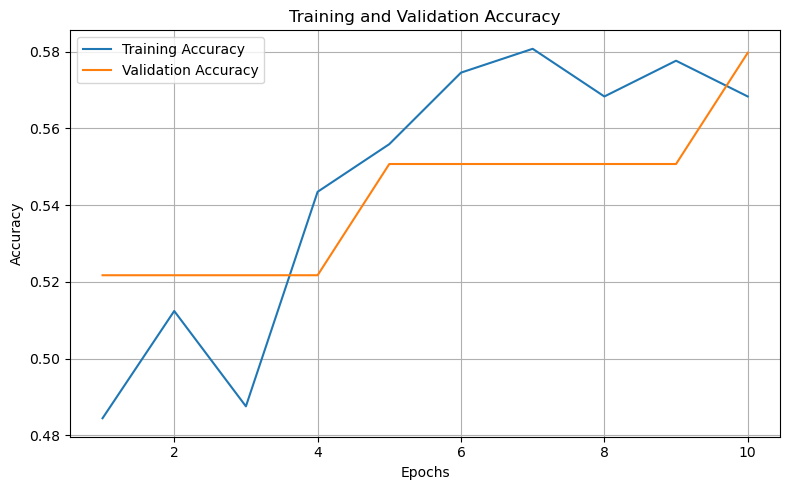

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


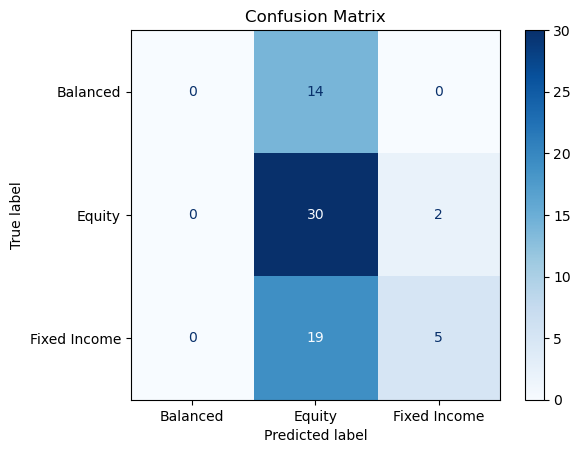




Num_words: 3500
maxlen: 200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4485 - loss: 1.1082 - val_accuracy: 0.5217 - val_loss: 0.9997
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5160 - loss: 1.0184 - val_accuracy: 0.5217 - val_loss: 0.9686
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5386 - loss: 0.9982 - val_accuracy: 0.5507 - val_loss: 0.9621
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5658 - loss: 0.9606 - val_accuracy: 0.5217 - val_loss: 0.9608
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5759 - loss: 0.8995 - val_accuracy: 0.6232 - val_loss: 0.9117
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5592 - loss: 0.9522 - val_accuracy: 0.5507 - val_loss: 0.8882
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5681 - loss: 0.9194 - val_accuracy: 0.5652 - val_loss: 0.8669
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6221 - loss: 0.8635 - val_accuracy: 0.6232 - v

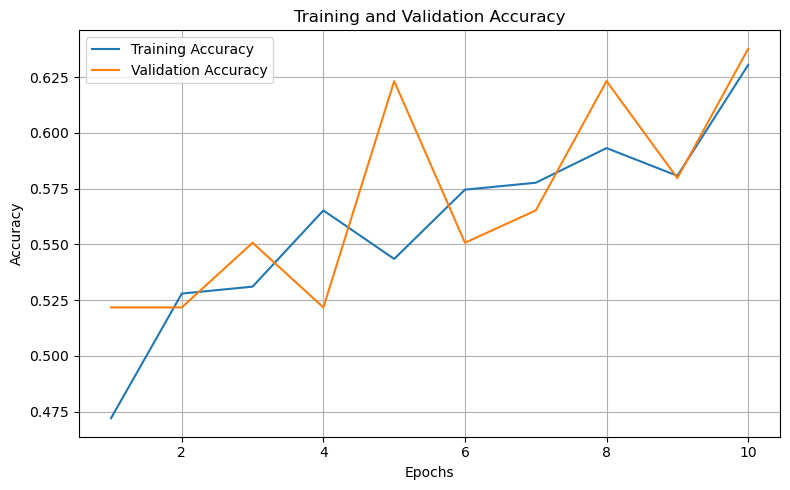

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


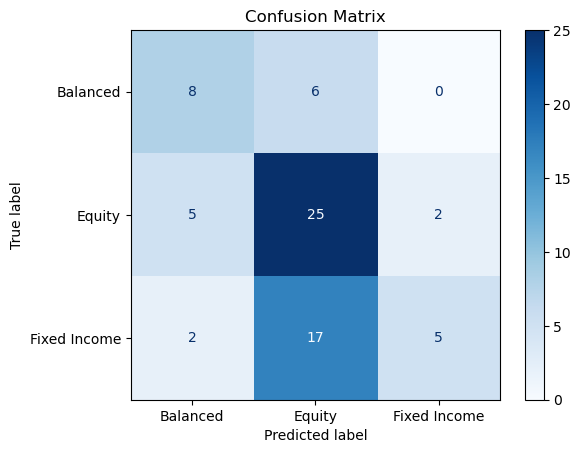




Num_words: 3500
maxlen: 300
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.4294 - loss: 1.1473 - val_accuracy: 0.5217 - val_loss: 1.0131
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5478 - loss: 1.0043 - val_accuracy: 0.5217 - val_loss: 0.9784
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5715 - loss: 0.9705 - val_accuracy: 0.5217 - val_loss: 0.9697
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5302 - loss: 0.9961 - val_accuracy: 0.5217 - val_loss: 0.9504
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5564 - loss: 0.9464 - val_accuracy: 0.5507 - val_loss: 0.9111
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5631 - loss: 0.8951 - val_accuracy: 0.5797 - val_loss: 0.8912
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6353 - loss: 0.8655 - val_accuracy: 0.5942 - val_loss: 0.8549
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6332 - loss: 0.8450 - val_accuracy: 0.6087 - val_loss: 0.

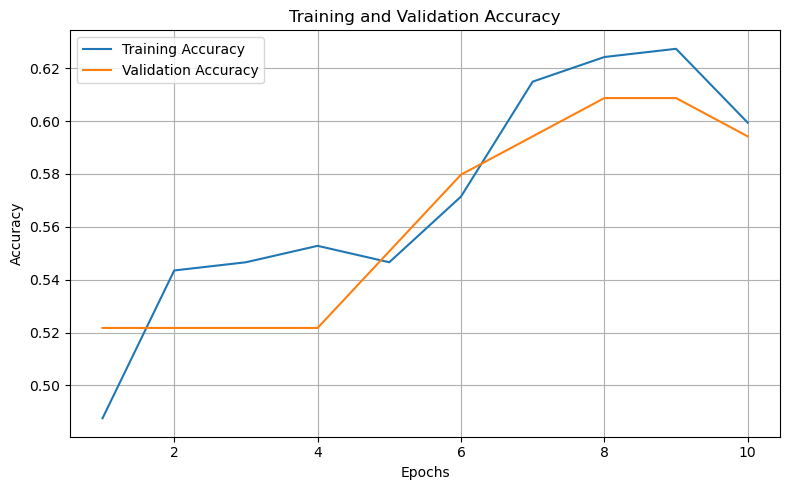

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


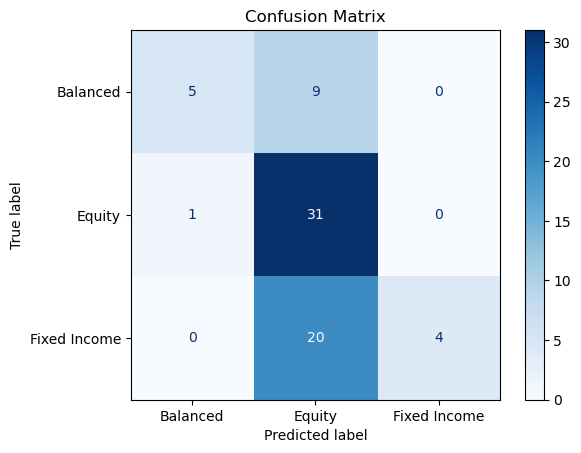




Num_words: 3500
maxlen: 400
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.4161 - loss: 1.1279 - val_accuracy: 0.5217 - val_loss: 0.9844
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5503 - loss: 0.9870 - val_accuracy: 0.5217 - val_loss: 0.9809
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5551 - loss: 0.9587 - val_accuracy: 0.5507 - val_loss: 0.9608
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5489 - loss: 0.9718 - val_accuracy: 0.5217 - val_loss: 0.9480
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6037 - loss: 0.8932 - val_accuracy: 0.6377 - val_loss: 0.9299
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5765 - loss: 0.9049 - val_accuracy: 0.5942 - val_loss: 0.8824
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5901 - loss: 0.8643 - val_accuracy: 0.6667 - val_loss: 0.8673
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5891 - loss: 0.8022 - val_accuracy: 0.6522 - val_loss: 0.

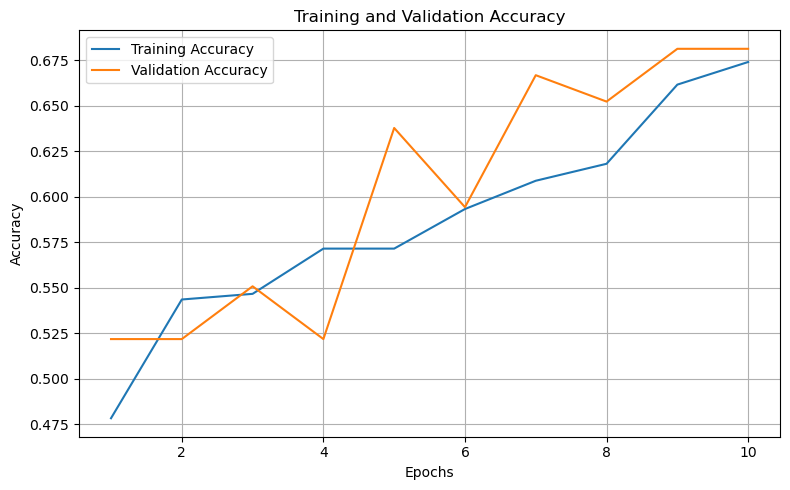

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


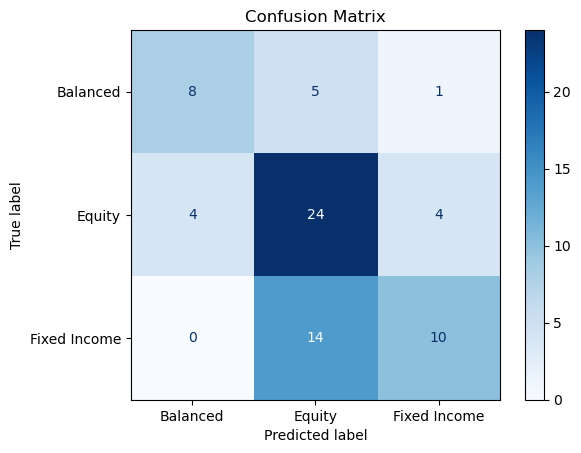




Num_words: 3500
maxlen: 500
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5029 - loss: 1.0521 - val_accuracy: 0.5217 - val_loss: 0.9782
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5734 - loss: 0.9862 - val_accuracy: 0.5217 - val_loss: 0.9904
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5114 - loss: 0.9983 - val_accuracy: 0.5217 - val_loss: 0.9526
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5158 - loss: 0.9957 - val_accuracy: 0.5217 - val_loss: 0.9474
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5509 - loss: 0.9211 - val_accuracy: 0.5942 - val_loss: 0.9134
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6177 - loss: 0.8848 - val_accuracy: 0.5797 - val_loss: 0.9058
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6747 - loss: 0.8267 - val_accuracy: 0.6087 - val_loss: 0.9033
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6070 - loss: 0.8825 - val_accuracy: 0.6232 - val_loss: 0

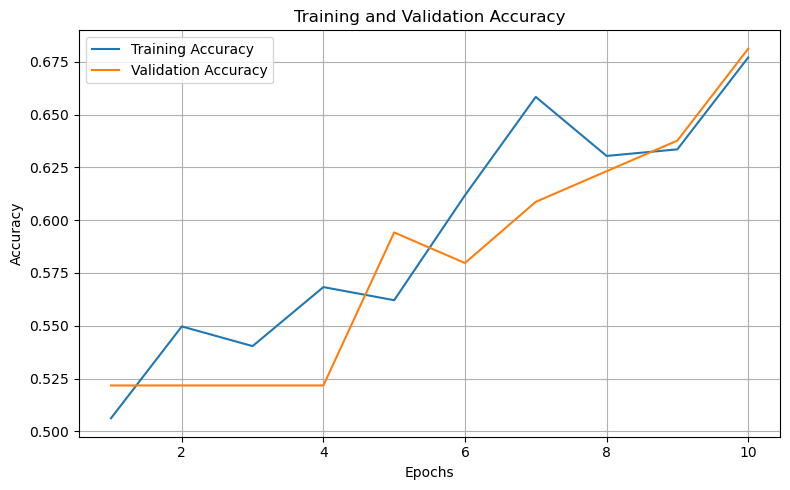

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


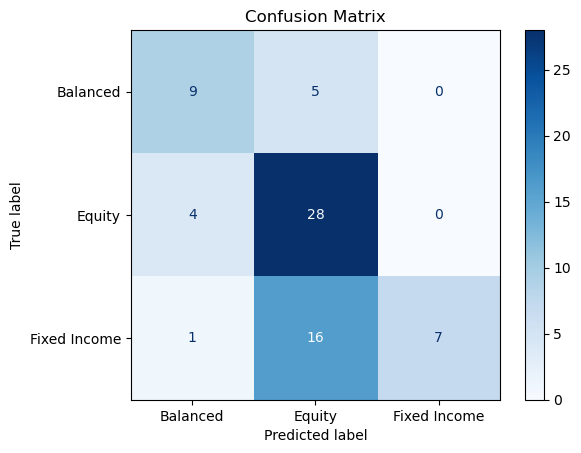




Num_words: 3500
maxlen: 600
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.4928 - loss: 1.0307 - val_accuracy: 0.5217 - val_loss: 1.0280
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4783 - loss: 1.0343 - val_accuracy: 0.5217 - val_loss: 1.0300
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5366 - loss: 1.0126 - val_accuracy: 0.5217 - val_loss: 0.9787
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5681 - loss: 0.9644 - val_accuracy: 0.5217 - val_loss: 0.9460
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5891 - loss: 0.8780 - val_accuracy: 0.6522 - val_loss: 0.9070
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5912 - loss: 0.9034 - val_accuracy: 0.5797 - val_loss: 0.9115
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6310 - loss: 0.8553 - val_accuracy: 0.6667 - val_loss: 0.9036
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.6436 - loss: 0.8358 - val_accuracy: 0.6232 - val_loss

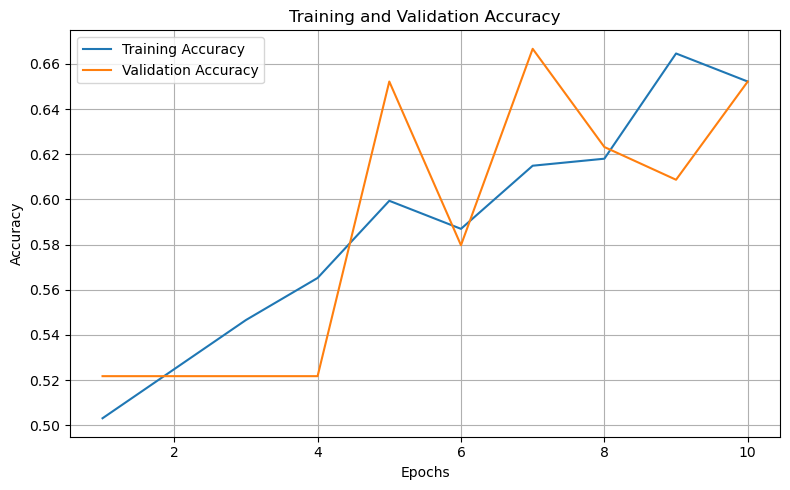

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


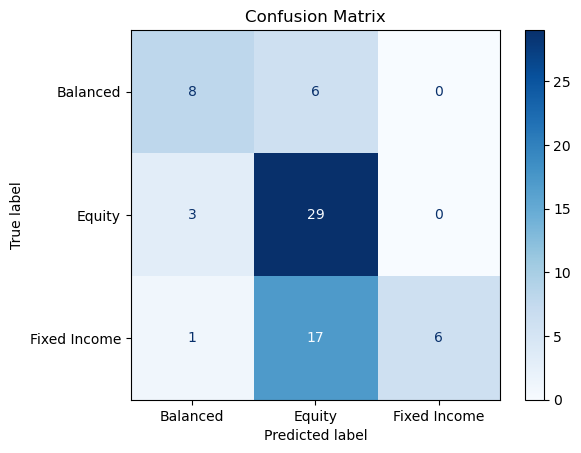




Num_words: 4500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.4859 - loss: 1.0563 - val_accuracy: 0.5217 - val_loss: 1.0325
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5520 - loss: 1.0004 - val_accuracy: 0.5217 - val_loss: 0.9914
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5515 - loss: 1.0245 - val_accuracy: 0.5217 - val_loss: 0.9973
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5623 - loss: 0.9838 - val_accuracy: 0.5217 - val_loss: 1.0019
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5315 - loss: 1.0543 - val_accuracy: 0.5217 - val_loss: 0.9919
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5174 - loss: 1.0225 - val_accuracy: 0.5217 - val_loss: 1.0150
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5695 - loss: 0.9926 - val_accuracy: 0.5507 - val_loss: 1.0004
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5507 - loss: 0.9853 - val_accuracy: 0.5507 - val_loss: 0.

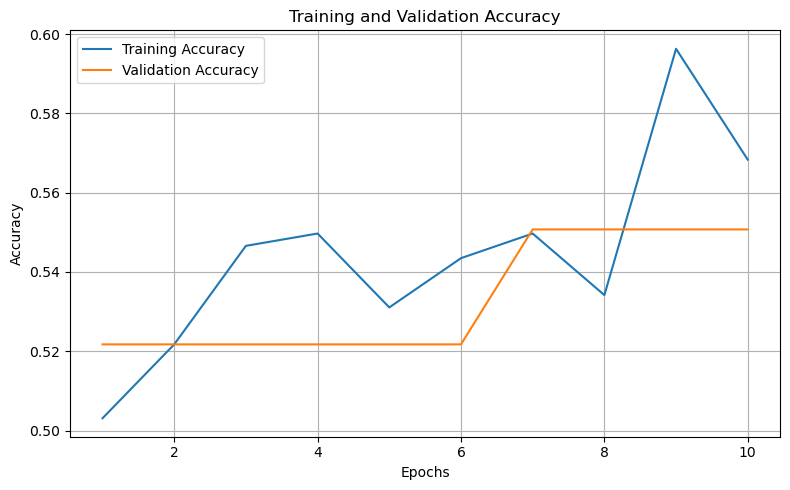

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


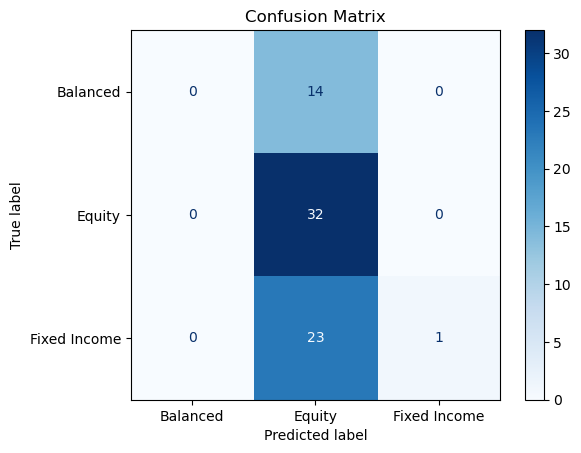




Num_words: 4500
maxlen: 200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.5143 - loss: 1.0888 - val_accuracy: 0.5072 - val_loss: 0.9915
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5572 - loss: 0.9637 - val_accuracy: 0.5652 - val_loss: 0.9847
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5146 - loss: 1.0088 - val_accuracy: 0.5217 - val_loss: 0.9795
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5685 - loss: 0.9509 - val_accuracy: 0.5507 - val_loss: 0.9736
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4834 - loss: 1.0099 - val_accuracy: 0.5507 - val_loss: 0.9537
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5266 - loss: 0.9792 - val_accuracy: 0.5507 - val_loss: 0.9199
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5981 - loss: 0.8865 - val_accuracy: 0.6087 - val_loss: 0.9117
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6038 - loss: 0.8956 - val_accuracy: 0.5507 - v

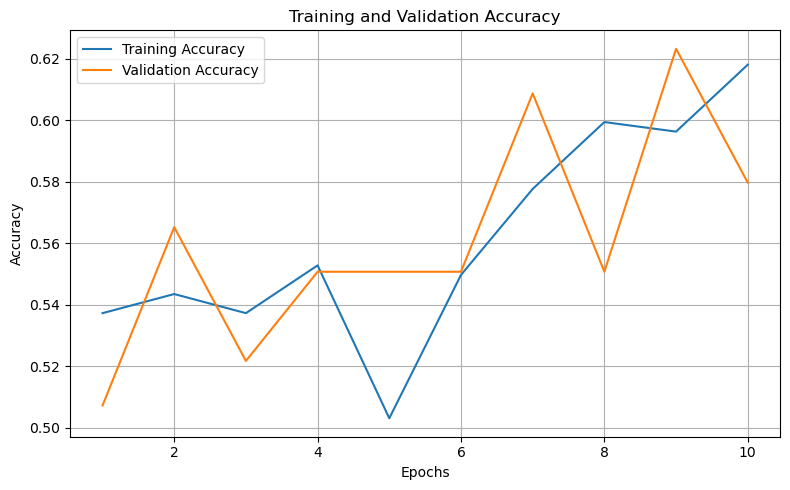

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


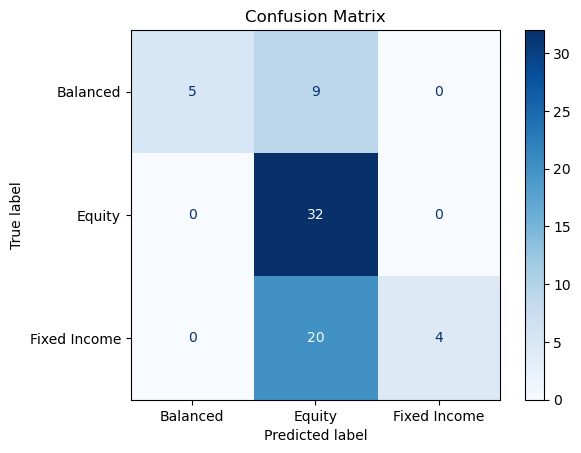




Num_words: 4500
maxlen: 300
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4723 - loss: 1.0744 - val_accuracy: 0.5217 - val_loss: 0.9922
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5665 - loss: 0.9690 - val_accuracy: 0.5217 - val_loss: 0.9537
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5646 - loss: 0.9537 - val_accuracy: 0.5217 - val_loss: 0.9428
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5781 - loss: 0.9226 - val_accuracy: 0.6667 - val_loss: 0.8989
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5722 - loss: 0.9352 - val_accuracy: 0.5797 - val_loss: 0.8716
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6008 - loss: 0.8460 - val_accuracy: 0.6522 - val_loss: 0.8857
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6130 - loss: 0.8473 - val_accuracy: 0.6957 - val_loss: 0.8561
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6367 - loss: 0.8443 - val_accuracy: 0.6377 - val_loss: 0.

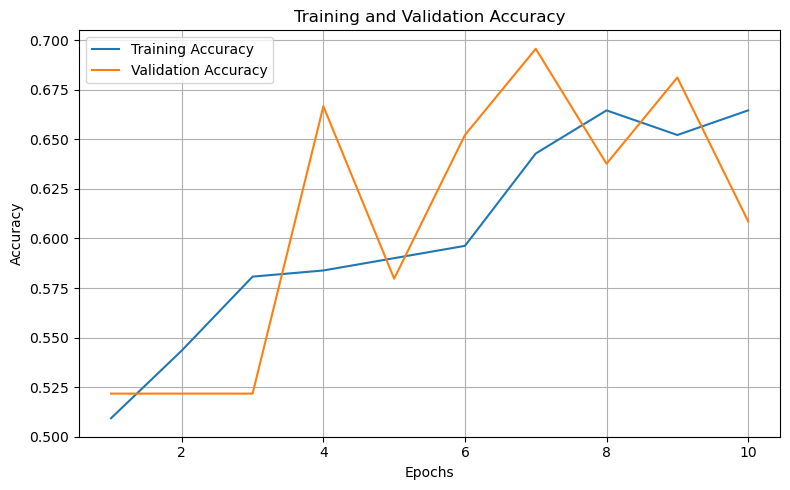

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


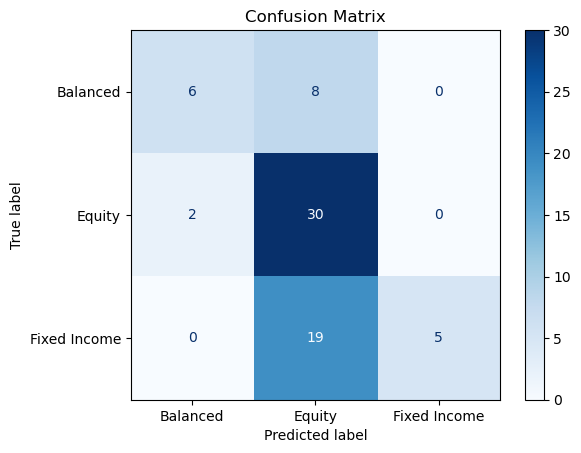




Num_words: 4500
maxlen: 400
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.4705 - loss: 1.0498 - val_accuracy: 0.5217 - val_loss: 0.9852
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5255 - loss: 0.9826 - val_accuracy: 0.5217 - val_loss: 0.9733
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5503 - loss: 0.9419 - val_accuracy: 0.5507 - val_loss: 0.9530
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5404 - loss: 0.9489 - val_accuracy: 0.5507 - val_loss: 0.9266
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5090 - loss: 0.9428 - val_accuracy: 0.5507 - val_loss: 0.9082
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5979 - loss: 0.8859 - val_accuracy: 0.5652 - val_loss: 0.9033
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6103 - loss: 0.8527 - val_accuracy: 0.5797 - val_loss: 0.8519
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6242 - loss: 0.8259 - val_accuracy: 0.6087 - val_loss: 0

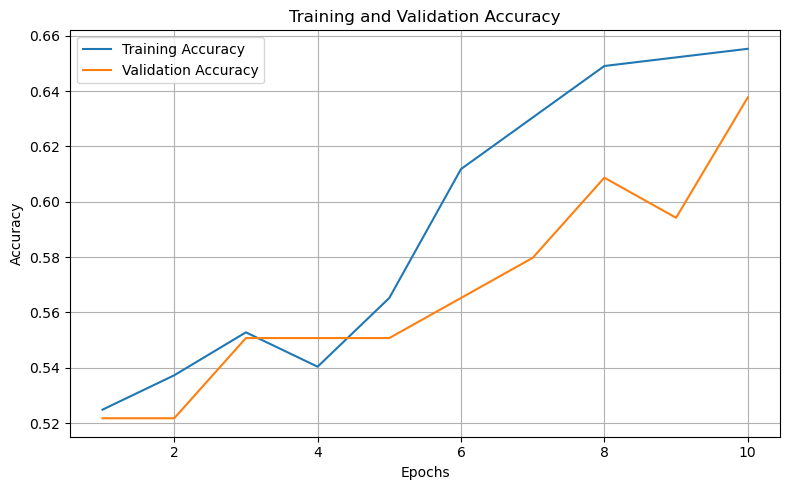

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


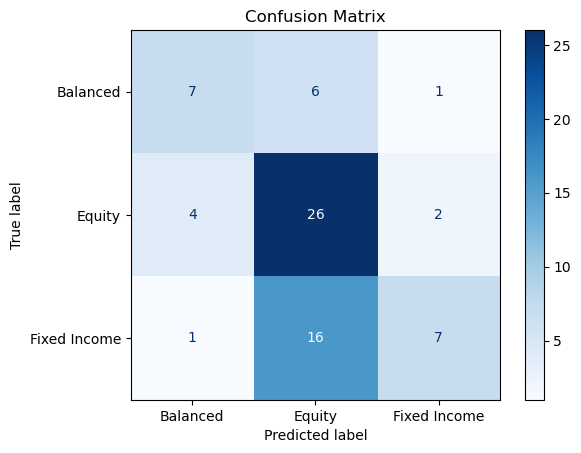




Num_words: 4500
maxlen: 500
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.4823 - loss: 1.0489 - val_accuracy: 0.5507 - val_loss: 0.9864
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5322 - loss: 0.9967 - val_accuracy: 0.5217 - val_loss: 0.9766
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5779 - loss: 0.9351 - val_accuracy: 0.5507 - val_loss: 0.9650
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5394 - loss: 0.9363 - val_accuracy: 0.5507 - val_loss: 0.9264
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5660 - loss: 0.9372 - val_accuracy: 0.5507 - val_loss: 0.9172
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5166 - loss: 0.9400 - val_accuracy: 0.5797 - val_loss: 0.9196
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5730 - loss: 0.9506 - val_accuracy: 0.6522 - val_loss: 0.8736
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6249 - loss: 0.8419 - val_accuracy: 0.6812 - val_loss: 0.

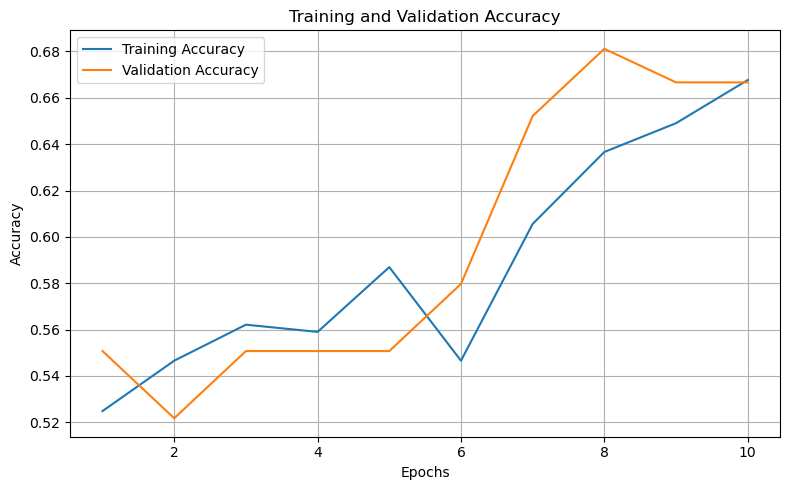

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


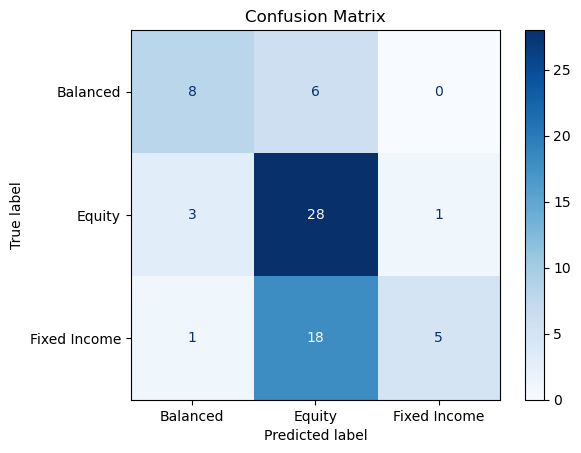




Num_words: 4500
maxlen: 600
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.4146 - loss: 1.0530 - val_accuracy: 0.5217 - val_loss: 1.0248
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5338 - loss: 1.0342 - val_accuracy: 0.5217 - val_loss: 0.9933
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5283 - loss: 0.9966 - val_accuracy: 0.5217 - val_loss: 0.9717
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5531 - loss: 0.9790 - val_accuracy: 0.5507 - val_loss: 0.9479
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5780 - loss: 0.8873 - val_accuracy: 0.6232 - val_loss: 0.9088
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6446 - loss: 0.8535 - val_accuracy: 0.6232 - val_loss: 0.9035
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6026 - loss: 0.9028 - val_accuracy: 0.6232 - val_loss: 0.8882
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6055 - loss: 0.8707 - val_accuracy: 0.5797 - val_loss: 

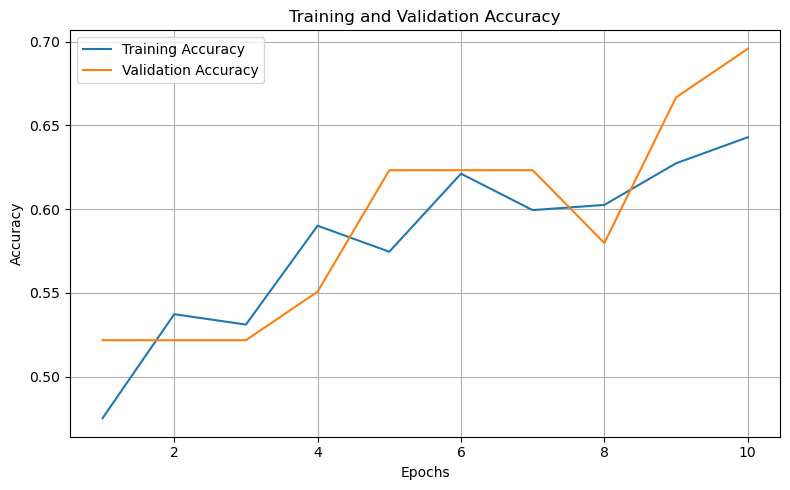

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


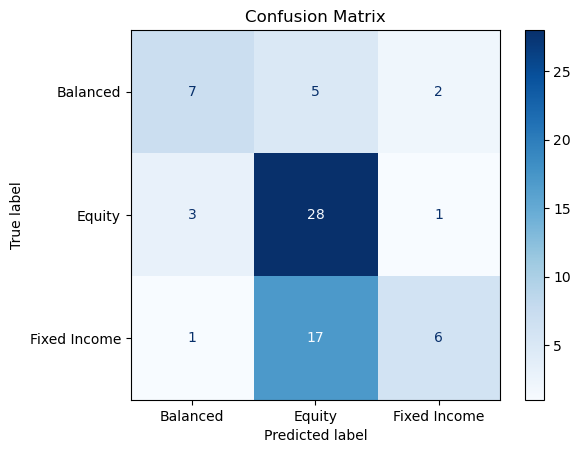

In [32]:
for num_words in [1500, 2500, 3500, 4500]:
    for maxlen in [100, 200, 300, 400, 500, 600]:
        print()
        print()
        print()
        print("Num_words: " + str(num_words))
        print("maxlen: " + str(maxlen))
        run_CNN(num_words, maxlen, 50)